# Working with Vital Signs and Concomitant Meds together

This notebook demonstrates how to clean and work with Vital Signs and Concomitant Meds. It cleans and merges them together, in order to plot blood pressure labels over time for those taking and not taking medication for hypertension.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pie.data_loader import DataLoader
from pie.data_preprocessor import DataPreprocessor

In [2]:
# Load and clean the data, and check we have the Vital Signs
data = DataLoader.load("../PPMI")
clean_df = data[DataLoader.MEDICAL_HISTORY]["Vital_Signs"]
print(clean_df.shape)
clean_df.head()

2025-05-13 15:01:41 data_loader.py [INFO] Biospecimen modality requested. Exclusion list: []
2025-05-13 15:01:41 data_loader.py [INFO] Loading subject_characteristics data...
2025-05-13 15:01:41 data_loader.py [WARNING] Directory not found: ../PPMI/_Subject_Characteristics
2025-05-13 15:01:41 data_loader.py [INFO] Loading medical_history data...
2025-05-13 15:01:41 med_hist_loader.py [WARNING] No CSV file found for prefix: Adverse_Event
2025-05-13 15:01:41 med_hist_loader.py [WARNING] No CSV file found for prefix: AV-133_Prodromal
2025-05-13 15:01:41 med_hist_loader.py [WARNING] No CSV file found for prefix: C05-05_PET_Imaging_Substudy
2025-05-13 15:01:41 med_hist_loader.py [WARNING] No CSV file found for prefix: Clinical_Diagnosis
2025-05-13 15:01:41 med_hist_loader.py [WARNING] No CSV file found for prefix: Clinical_Global_Impression
2025-05-13 15:01:41 med_hist_loader.py [WARNING] No CSV file found for prefix: Determination_of_Freezing_and_Falls
2025-05-13 15:01:41 med_hist_loader.p

/Users/vic/Projects/MJFF/PIE/pie/med_hist_loader.py:142: DtypeWarning: Columns (6,7,13,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(csv_file)


2025-05-13 15:01:41 med_hist_loader.py [WARNING] No CSV file found for prefix: Primary_Clincial_Diagnosis
2025-05-13 15:01:41 med_hist_loader.py [WARNING] No CSV file found for prefix: Procedure_for_PD_Log
2025-05-13 15:01:41 med_hist_loader.py [WARNING] No CSV file found for prefix: Report_of_Pregnancy
2025-05-13 15:01:41 med_hist_loader.py [WARNING] No CSV file found for prefix: SVA2_PET_Imaging_Substudy
2025-05-13 15:01:41 med_hist_loader.py [WARNING] No CSV file found for prefix: Tau_Substudy
2025-05-13 15:01:42 data_preprocessor.py [INFO] There are 51 null LEDD values remaining after cleaning
2025-05-13 15:01:42 data_preprocessor.py [INFO] There are 78 concomitant medication entries with no start date.
2025-05-13 15:01:42 data_preprocessor.py [INFO] There are 21696 concomitant medication entries with no stop date.
2025-05-13 15:01:43 data_loader.py [INFO] Loaded 5 medical_history tables
2025-05-13 15:01:51 data_loader.py [INFO] Loading motor_assessments data...
2025-05-13 15:01:51

,REC_ID,PATNO,EVENT_ID,PAG_NAME,INFODT,WGTKG,HTCM,TEMPC,BPARM,SYSSUP,...,HRSUP,SYSSTND,DIASTND,HRSTND,ORIG_ENTRY,LAST_UPDATE,Sup BP code,Sup BP label,Stnd BP code,Stnd BP label
0,272450501,3000,BL,VITAL,02/2011,64.0,167.0,35.9,1.0,126.0,...,60.0,130.0,70.0,60.0,02/2011,2020-06-25 16:02:19.0,1,Elevated,2,Stage 1 HTN
1,269555901,3000,SC,VITAL,01/2011,NaN,NaN,36.7,1.0,134.0,...,68.0,156.0,76.0,84.0,01/2011,2020-06-25 16:02:21.0,2,Stage 1 HTN,2,Stage 1 HTN
2,288344701,3000,V01,VITAL,04/2011,NaN,NaN,36.8,1.0,153.0,...,64.0,147.0,58.0,74.0,04/2011,2020-06-25 16:02:21.0,2,Stage 1 HTN,2,Stage 1 HTN
3,308428901,3000,V02,VITAL,08/2011,NaN,NaN,37.6,2.0,110.0,...,68.0,118.0,70.0,72.0,08/2011,2020-06-25 16:02:21.0,0,Normal,0,Normal
4,319985101,3000,V03,VITAL,11/2011,NaN,NaN,37.4,1.0,119.0,...,100.0,120.0,67.0,79.0,11/2011,2020-06-25 16:02:21.0,0,Normal,1,Elevated


In [3]:
# Check the mapped blood pressure readings to a label
print(clean_df.columns.tolist())
clean_df["Sup BP label"].value_counts()

['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'INFODT', 'WGTKG', 'HTCM', 'TEMPC', 'BPARM', 'SYSSUP', 'DIASUP', 'HRSUP', 'SYSSTND', 'DIASTND', 'HRSTND', 'ORIG_ENTRY', 'LAST_UPDATE', 'Sup BP code', 'Sup BP label', 'Stnd BP code', 'Stnd BP label']


Sup BP label
Stage 1 HTN            13175
Normal                  5713
Elevated                3851
Stage 2 HTN             2156
Hypertensive crisis      143
Name: count, dtype: int64

In [4]:
# How many patients have a different Supine label from Standing label?
clean_df[clean_df["Sup BP label"]!=clean_df["Stnd BP label"]]["PATNO"].nunique()

3298

In [5]:
# How many patients have the same Supine label throughout PPMI?
counts = clean_df.groupby("PATNO")["Sup BP label"].nunique()
counts[counts==1].shape[0]

2335

## Visualizing vital signs

Let's take a look at the Supine Blood Pressure labels over time. To make a more interesting plot, we'll separate out those patients taking medication for hypertension from those not on hypertension meds.

The steps to achieve this include:

* Convert the EVENT_ID of the BP readings to PPMI months (to see the trend over time).
* Clean the Concomitant Meds, to see which patients are on medication for HTN.
* Merge Vital Signs and Comorbidities derived from meds, then plot.

In [6]:
# Convert the EVENT_ID to PPMI months
clean_df["PPMI Months"] = clean_df["EVENT_ID"].apply(lambda ev: DataPreprocessor.event_id_to_months(ev))
clean_df["PPMI Months"].value_counts()

PPMI Months
 0.0      4058
 12.0     2798
-3.0      2717
 6.0      1981
 24.0     1734
 18.0     1649
 36.0     1195
 48.0      995
 30.0      963
 60.0      940
 42.0      806
 3.0       705
 72.0      672
 84.0      660
 9.0       635
 54.0      629
 96.0      453
 120.0     310
 108.0     288
 132.0     250
 144.0     194
 156.0     100
 168.0      13
Name: count, dtype: int64

In [7]:
# Clean the Concomitant Meds and convert into Comorbidities
clean_meds = DataPreprocessor.clean_concomitant_meds(
    data[DataLoader.MEDICAL_HISTORY]["Concomitant_Medication"])
print(clean_meds.columns.tolist())
comorbs = clean_meds.pivot_table(index="PATNO", columns="CMINDC_TEXT", values="CMINDC",
                                 aggfunc=lambda v: 1, fill_value=0)
comorbs.head()

2025-05-13 15:01:52 data_preprocessor.py [INFO] There are 78 concomitant medication entries with no start date.
2025-05-13 15:01:52 data_preprocessor.py [INFO] There are 21696 concomitant medication entries with no stop date.
['REC_ID', 'PATNO', 'EVENT_ID', 'PAG_NAME', 'CMTRT', 'CMDOSE', 'CMDOSU', 'CMDOSFRQ', 'ROUTE', 'STARTDT', 'STOPDT', 'ONGOING', 'CMINDC', 'CMINDC_TEXT', 'TOTDDOSE', 'RECNO', 'SEQNO1', 'SEQNO2', 'WHODRUG', 'EXCLMED', 'ORIG_ENTRY', 'LAST_UPDATE']


CMINDC_TEXT,Anxiety,Atrial Fibrillation / Arrhythmias,Benign Prostatic Hypertrophy / Overactive Bladder,Cognitive Dysfunction,Congestive Heart Failure,Constipation,"Coronary Artery Disease, Peripheral Artery Disease, Stroke",Daytime Sleepiness,"Delusions, Hallucination, Psychosis",Depression,...,Nausea,Other,Pain,REM-Behavior Disorder,Restless Leg Syndrome,Sexual Dysfunction,Sialorrhea / Drooling,Supplements / Homeopathic Medication,Thyroid Disorder,Vitamins / Coenzymes
PATNO,,,,,,,,,,,,,,,,,,,,,
3000,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
3001,0,0,1,0,0,1,0,0,0,0,...,0,1,1,0,0,0,0,1,0,0
3002,0,0,0,0,0,1,0,0,0,0,...,0,1,1,0,0,0,0,1,1,1
3003,1,0,1,0,0,1,0,0,0,0,...,0,1,1,0,0,0,0,1,1,1
3004,0,1,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,1,0,1


In [8]:
# Merge onto Vital Signs
clean_df = clean_df.merge(comorbs, how="left", left_on="PATNO", right_index=True)
clean_df.head()

,REC_ID,PATNO,EVENT_ID,PAG_NAME,INFODT,WGTKG,HTCM,TEMPC,BPARM,SYSSUP,...,Nausea,Other,Pain,REM-Behavior Disorder,Restless Leg Syndrome,Sexual Dysfunction,Sialorrhea / Drooling,Supplements / Homeopathic Medication,Thyroid Disorder,Vitamins / Coenzymes
0,272450501,3000,BL,VITAL,02/2011,64.0,167.0,35.9,1.0,126.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,269555901,3000,SC,VITAL,01/2011,NaN,NaN,36.7,1.0,134.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,288344701,3000,V01,VITAL,04/2011,NaN,NaN,36.8,1.0,153.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,308428901,3000,V02,VITAL,08/2011,NaN,NaN,37.6,2.0,110.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,319985101,3000,V03,VITAL,11/2011,NaN,NaN,37.4,1.0,119.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


<Axes: xlabel='PPMI Months', ylabel='Sup BP code'>

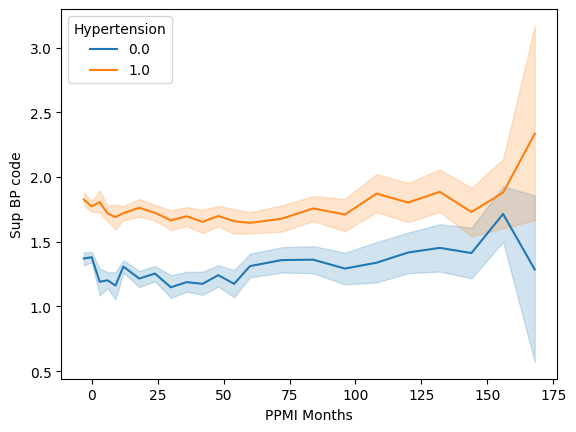

In [9]:
# Create a lineplot showing Supine BP over time, for those on and not on hypertension meds
sns.lineplot(data=clean_df, x="PPMI Months", y="Sup BP code", hue="Hypertension")

We can see that those on medication for hypertension have consistently higher BP codes than those not taking medication. In addition, both groups show a general increase in BP over the study period, although the increase is smaller than the between-group difference. Finally, the confidence intervals increase towards the end of the study period, as the number of patients decreases.